# Ordinal analysis of the MTurk Experiment (non-centered, ANOVA style)

In [2]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sb
import pymc3 as pm

import theano.tensor as tt
from theano.compile.ops import as_op

from scipy.stats import norm
from scipy.stats import t as studentT

from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')


from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Gill Sans MT']


/Users/harisundaram/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data

In [12]:
# Using dtype 'category' for Y

df = pd.read_csv(
    'data/all_item_output_926.csv',
    dtype={
        'y': 'int',
        'gesture': 'int',
        'dist': 'int',
        'shading': 'int',
        'cond': 'int',
        'comicleft': 'int'
    })

df.rename(columns={'dist':'distance', 'cond':'framing'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 6 columns):
gesture      655 non-null int64
distance     655 non-null int64
shading      655 non-null int64
y            655 non-null int64
framing      655 non-null int64
comicleft    655 non-null int64
dtypes: int64(6)
memory usage: 30.8 KB


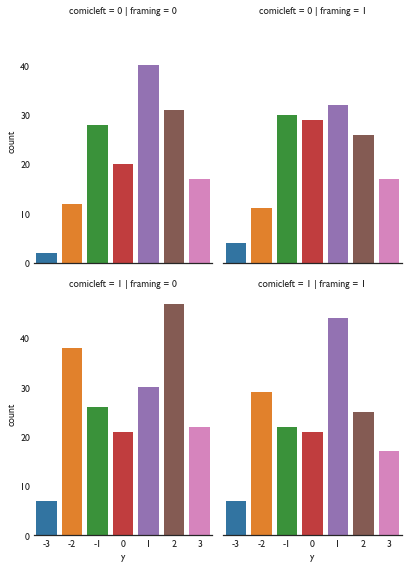

In [14]:
g_color = sb.factorplot(
    x="y",
    row="comicleft",
    col="framing",
    data=df,
    kind="count",
    size=4,
    aspect=0.7)
g_color.despine(left=True)
g_color.savefig("main factor-responses across conditions.pdf")

In [15]:
# Calculate Gamma shape and rate from mode and sd.
# if using gamma prior for the class dependent sigma

def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [16]:
df['framing'] = df['framing'].astype('category')
df['gesture'] = df['gesture'].astype('category')
df['distance'] = df['distance'].astype('category')
df['shading'] = df['shading'].astype('category')
df['comicleft'] = df['comicleft'].astype('category')

In [18]:
df.y.nunique()

7

In [20]:
# levels for the ordinal case

y_cat = (df['y']).astype('category')  # in range 1-7 

nYlevels = df.y.nunique()
thresh = [k + 0.5
           for k in range(1, nYlevels)]  # fixing the boundaries in our case
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))

#initial probabilities
pr_test_val = df.groupby('y').size()/df.shape[0]
print("Overall Category Probabilities: {}".format(pr_test_val.round(3)))

thresh:	[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs:	[1.5 -- -- -- -- 6.5]
Overall Category Probabilities: y
-3    0.031
-2    0.137
-1    0.162
 0    0.139
 1    0.223
 2    0.197
 3    0.111
dtype: float64


In [21]:
# defining the operator to compute the probabilities:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((mu.size, nYlevels))
    n = norm(loc=mu, scale=sigma)
    out[:, 0] = n.cdf(theta[0])
    out[:, 1] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:, 2] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:, 3] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:, 4] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:, 5] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:, 6] = 1 - n.cdf(theta[5])
    return out

In [30]:
y = df.y
yMean = y.mean()
ySD = y.std()
print("Response (y), Mean: {}, Sigma: {}".format(yMean.round(3), ySD.round(3)))

# different nominal predictors



# gesture

x1 = df.gesture.cat.codes.values # array specifying index of 'gesture' conditions
Nx1Lvl = len(df.gesture.cat.categories) # number of gestures


# shading

x2 = df.shading.cat.codes.values # array specifying index of 'shading' conditions
Nx2Lvl = len(df.shading.cat.categories) # number of shades

# distance

x3 = df.distance.cat.codes.values # array specifying index of 'distance' conditions
Nx3Lvl = len(df.distance.cat.categories) # number of distance

# framing
x4 = df.framing.cat.codes.values # array specifying index of 'framing' conditions
Nx4Lvl = len(df.framing.cat.categories) # number of frames

# comicleft
x5 = df.comicleft.cat.codes.values # array specifying index of 'comicleft' conditions
Nx5Lvl = len(df.comicleft.cat.categories) # number of comicleft



#setting the values of the gamma prior based on the standard deviation
agammaShRa = gammaShRaFromModeSD(ySD/2 , 2*ySD)
print("gamma parameters: {}".format(agammaShRa))

Response (y), Mean: 0.423, Sigma: 1.681
gamma parameters: (1.2831955546343297, 0.3369544389891897)


In [31]:
Nx5Lvl

2

In [32]:
with pm.Model() as ordinal_factor_model_main:

    theta = pm.Normal(
        'theta',
        mu=thresh,
        tau=np.repeat(1 / 2**2, len(thresh)),
        shape=len(thresh),
        observed=thresh_obs,
        testval=thresh)

    # intercept
    a0_tilde = pm.Normal('a0_tilde', mu=0, sd=1)
    a0 = pm.Deterministic('a0', yMean + ySD * 5 * a0_tilde)

    # gesture
    a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    a1_tilde = pm.Normal('a1_tilde', mu=0, sd=1, shape=Nx1Lvl)
    a1 = pm.Deterministic('a1', 0.0 + a1SD * a1_tilde)

    # shading
    a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    a2_tilde = pm.Normal('a2_tilde', mu=0, sd=1, shape=Nx2Lvl)
    a2 = pm.Deterministic('a2', 0.0 + a2SD * a2_tilde)

    # distance
    a3SD = pm.Gamma('a3SD', agammaShRa[0], agammaShRa[1])
    a3_tilde = pm.Normal('a3_tilde', mu=0, sd=1, shape=Nx3Lvl)
    a3 = pm.Deterministic('a3', 0.0 + a3SD * a3_tilde)

    # framing
    a4SD = pm.Gamma('a4SD', agammaShRa[0], agammaShRa[1])
    a4_tilde = pm.Normal('a4_tilde', mu=0, sd=1, shape=Nx4Lvl)
    a4 = pm.Deterministic('a4', 0.0 + a4SD * a4_tilde)

    # comicleft
    a5SD = pm.Gamma('a5SD', agammaShRa[0], agammaShRa[1])
    a5_tilde = pm.Normal('a5_tilde', mu=0, sd=1, shape=Nx4Lvl)
    a5 = pm.Deterministic('a5', 0.0 + a5SD * a5_tilde)

    # gesture x shading
    a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
    a1a2_tilde = pm.Normal('a1a2_tilde', mu=0, sd=1, shape=(Nx1Lvl, Nx2Lvl))
    a1a2 = pm.Deterministic('a1a2', 0.0 + a1a2SD * a1a2_tilde)

    # gesture x distance
    a1a3SD = pm.Gamma('a1a3SD', agammaShRa[0], agammaShRa[1])
    a1a3_tilde = pm.Normal('a1a3_tilde', mu=0, sd=1, shape=(Nx1Lvl, Nx3Lvl))
    a1a3 = pm.Deterministic('a1a3', 0.0 + a1a3SD * a1a3_tilde)

    # distance x shading
    a2a3SD = pm.Gamma('a2a3SD', agammaShRa[0], agammaShRa[1])
    a2a3_tilde = pm.Normal('a2a3_tilde', mu=0, sd=1, shape=(Nx2Lvl, Nx3Lvl))
    a2a3 = pm.Deterministic('a2a3', 0.0 + a2a3SD * a2a3_tilde)

    mu = a0 + a1[x1] + a2[x2] + a3[x3] + a4[x4] + a5[x5] + a1a2[x1,
                                                                x2] + a1a3[x1,
                                                                           x3] + a2a3[x2,
                                                                                      x3]
    ySigma = pm.Uniform('ySigma', ySD / 100, ySD * 10)

    pr = outcome_probabilities(theta, mu, ySigma)
    y = pm.Categorical(
        'Y_obs', pr, observed=y_cat.cat.codes, testval=pr_test_val)

In [33]:
with ordinal_factor_model_main:
    step1 = pm.Metropolis()
    trace = pm.sample(10000, step=step1)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ySigma_interval__]
>Metropolis: [a2a3_tilde]
>Metropolis: [a2a3SD_log__]
>Metropolis: [a1a3_tilde]
>Metropolis: [a1a3SD_log__]
>Metropolis: [a1a2_tilde]
>Metropolis: [a1a2SD_log__]
>Metropolis: [a5_tilde]
>Metropolis: [a5SD_log__]
>Metropolis: [a4_tilde]
>Metropolis: [a4SD_log__]
>Metropolis: [a3_tilde]
>Metropolis: [a3SD_log__]
>Metropolis: [a2_tilde]
>Metropolis: [a2SD_log__]
>Metropolis: [a1_tilde]
>Metropolis: [a1SD_log__]
>Metropolis: [a0_tilde]
>Metropolis: [theta_missing]
100%|██████████| 10500/10500 [49:06<00:00,  3.56it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [34]:
import pickle #

with open('ordinal_factor_model_main.pkl', 'wb') as buff:
    pickle.dump({'model': ordinal_factor_model_main, 'trace': trace}, buff)
  
# with open('my_model.pkl', 'rb') as buff:
#     data = pickle.load(buff)  

# basic_model, trace = data['model'], data['trace']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c28718320>,
      dtype=object)

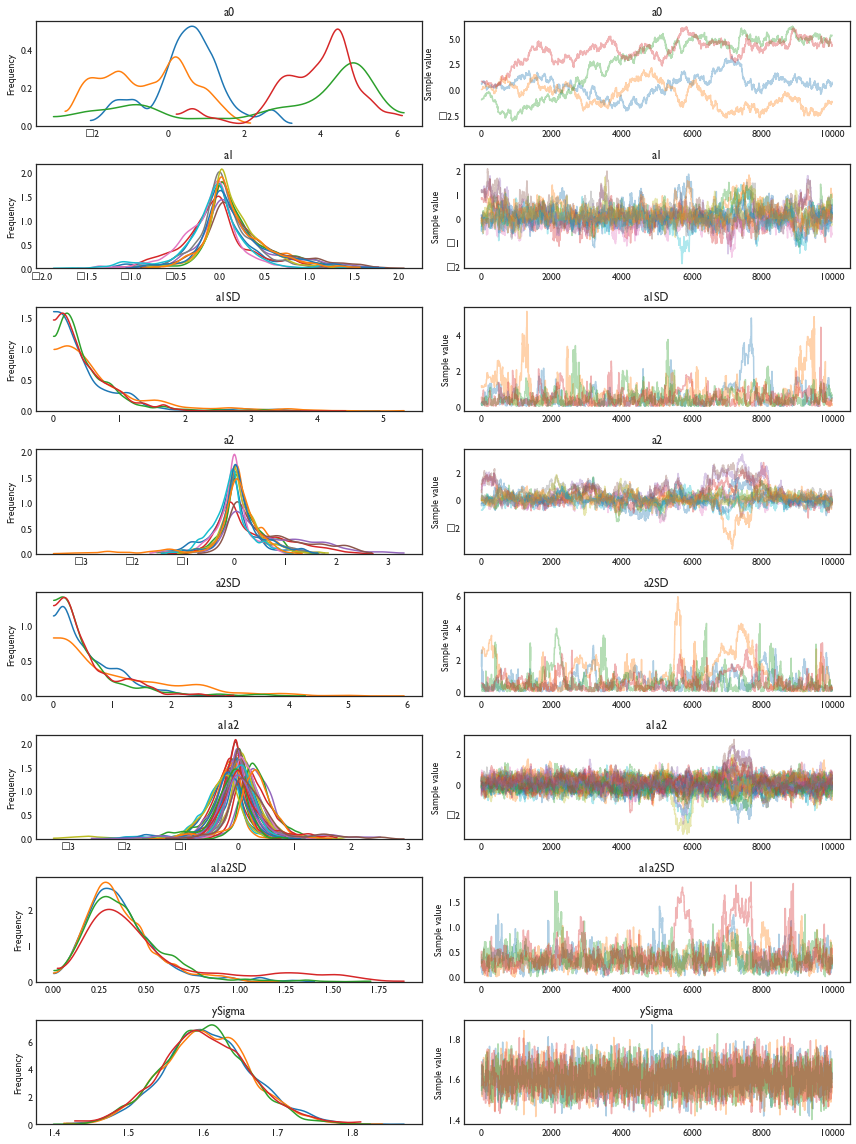

In [35]:
pm.traceplot(trace, varnames=['a0', 'a1', 'a1SD', 'a2', 'a2SD', 'a1a2', 'a1a2SD', 'ySigma'])

In [27]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl, Nx2Lvl, len(trace[a0]))) # notice that this isn't len(trace)
b1b2 = m.copy()

for (j1, j2) in np.ndindex(Nx1Lvl, Nx2Lvl):
    m[j1, j2] = (trace['a0'] + 
                 trace['a1'][:, j1] +
                 trace['a2'][:, j2] +
                 trace['a1a2'][:, j1, j2])

b0 = np.mean(m, axis=(0, 1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0

for (j1, j2) in np.ndindex(Nx1Lvl, Nx2Lvl):
    b1b2[j1, j2] = (m[j1, j2] - (b0 + b1[j1] + b2[j2]))

# Below are the values corresponding to the first column of table 20.2
print('b0: {}'.format(np.mean(b0).round(3)))
print('b1: {}'.format(np.mean(b1, axis=1).round(3)))
print('b2: {}'.format(np.mean(b2, axis=1).round(3)))
print('b1b2: {}'.format(np.mean(b1b2, axis=2).round(3)))
print('ySigma: {}'.format(np.mean(trace['ySigma']).round(3)))

b0: 4.271
b1: [-0.147  0.147]
b2: [ 0.019 -0.09   0.071]
b1b2: [[ 0.048 -0.04  -0.009]
 [-0.048  0.04   0.009]]
ySigma: 1.457


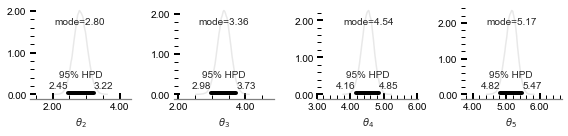

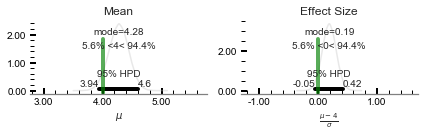

In [58]:
sigma = trace['ySigma']
nm = (b0 - 4) / sigma  # effect size

# plot theta posterior

NRows = 1  # change based on the number of parameters
NCols = 4  # four interior values
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    trace['theta_missing'][:, 0],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    color='0.75',
    ax=axs3[0],
    text_size=10)
pm.plot_posterior(
    trace['theta_missing'][:, 1],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    color='0.75',
    ax=axs3[1],
    text_size=10)
pm.plot_posterior(
    trace['theta_missing'][:, 2],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    round_to=2,
    ax=axs3[2],
    text_size=10)
pm.plot_posterior(
    trace['theta_missing'][:, 3],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[3],
    round_to=2,
    text_size=10)

# beta_vars = ['intercept', 'color', 'location', 'condition']
for j in range(NCols):
    z = axs3[j]
    #     z.set_xlabel("") # no individual labels
    #     z.set_ylabel("")
    s = "$\\theta_{{{0}}}$".format(j + 2)
    z.set_xlabel("{0}".format(s))
    center = trace['theta_missing'][:, j].mean()
    z.set_xlim([center - 1.5, center + 1.5])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()

fig3.tight_layout()

fig3.savefig("factors_theta_values_color.pdf")

# mean and mean effect size

fig2, axs2 = sb.mpl.pyplot.subplots(1, 2)  #### change on changing parameters
fig2.set_size_inches(6, 2)

pm.plot_posterior(
    b0,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[0],
    ref_val=4,
    round_to=2,
    text_size=10)
pm.plot_posterior(
    nm,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[1],
    ref_val=0,
    round_to=2,
    text_size=10)

axs2[0].set_title(r"Mean")
b0m = np.mean(b0)
axs2[0].set_xlim([b0m - 1.5, b0m + 1.5])
axs2[0].set_xlabel(r'$\mu$')

axs2[1].set_title(r"Effect Size")
nmm = np.mean(nm)
axs2[1].set_xlim([nmm - 1.5, nmm + 1.5])
axs2[1].set_xlabel(r'$\frac{\mu-4}{\sigma}$')

axs2[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].tick_params(
    direction='in', length=6, width=2, colors='k', which='major')
axs2[0].tick_params(
    direction='in', length=4, width=1, colors='k', which='minor')
axs2[0].xaxis.set_ticks_position('bottom')
axs2[0].yaxis.set_ticks_position('left')
axs2[0].minorticks_on()

axs2[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].tick_params(
    direction='in', length=6, width=2, colors='k', which='major')
axs2[1].tick_params(
    direction='in', length=4, width=1, colors='k', which='minor')
axs2[1].xaxis.set_ticks_position('bottom')
axs2[1].yaxis.set_ticks_position('left')
axs2[1].minorticks_on()

fig2.tight_layout()
fig2.savefig("factors_mean_effect_color.pdf")

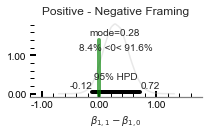

In [62]:
contrast = b1[1, :] - b1[0, :]

fig, axs = sb.mpl.pyplot.subplots(1, 1)  #### change on changing parameters
fig.set_size_inches(3, 2)

pm.plot_posterior(
    contrast,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    round_to=2,
    ax=axs,
    ref_val=0,
    text_size=10)

axs.set_title(r"Positive - Negative Framing")
cm = np.mean(contrast)
axs.set_xlim([cm - 1.5, cm + 1.5])
axs.set_xlabel(r'$\beta_{1,1} - \beta_{1,0}$')

axs.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs.tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs.xaxis.set_ticks_position('bottom')
axs.yaxis.set_ticks_position('left')
axs.minorticks_on()
fig.tight_layout()
fig.savefig("factors_framing_contrasts_color.pdf")